In [1]:
# Datasets:
# curl -0  https://www.thedatum.org/datasets/TSB-AD-M.zip
import numpy as np
import pandas as pd

In [2]:
from SAE_LSTM import SAE_LSTM

In [3]:
from datasets import read_dataset_semisupervised

X_train, y_train, X_test, y_test = [], [], [], []
for key, value in read_dataset_semisupervised("MSL").items():
    X_train.append(value[0])
    y_train.append(value[1])
    X_test.append(value[2])
    y_test.append(value[3])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Anomalies in test set:", np.sum(y_test))

012_MSL_id_11_Sensor_tr_539_1st_940.csv
015_MSL_id_14_Sensor_tr_575_1st_1250.csv
017_MSL_id_16_Sensor_tr_512_1st_1850.csv
013_MSL_id_12_Sensor_tr_554_1st_1200.csv
005_MSL_id_4_Sensor_tr_855_1st_2700.csv
002_MSL_id_1_Sensor_tr_500_1st_900.csv
010_MSL_id_9_Sensor_tr_554_1st_1172.csv
014_MSL_id_13_Sensor_tr_1525_1st_4575.csv
006_MSL_id_5_Sensor_tr_1150_1st_1250.csv
011_MSL_id_10_Sensor_tr_1525_1st_4590.csv
009_MSL_id_8_Sensor_tr_714_1st_1390.csv
008_MSL_id_7_Sensor_tr_656_1st_1630.csv
004_MSL_id_3_Sensor_tr_530_1st_630.csv
003_MSL_id_2_Sensor_tr_883_1st_1238.csv
007_MSL_id_6_Sensor_tr_980_1st_3550.csv
016_MSL_id_15_Sensor_tr_500_1st_780.csv
Train shape: (12575, 55)
Test shape: (37335, 55)
Anomalies in test set: 2327


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using CUDA device


In [5]:
from utils import create_sequences, go_back_to_original_shape

In [6]:
from sklearn.metrics import classification_report

seq_len = 50
# validation_split = 0.2
# validation_split_index = int(len(X_train) * (1 - validation_split))
# # X_val = X_train[validation_split_index:]
# X_train = X_train[:validation_split_index]
# y_train = y_train[:validation_split_index]

X_train_sequences = create_sequences(X_train, seq_len, step=1)
y_train_sequences = create_sequences(y_train, seq_len, step=1)
print(f"sequences_train.shape: {X_train_sequences.shape}")
print(f"y_train.shape: {y_train_sequences.shape}")
train_dataset = TensorDataset(
    torch.Tensor(X_train_sequences), torch.Tensor(y_train_sequences)
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=False
)

# sequences_val = create_sequences(X_val, seq_len, step=1)
# val_dataset = TensorDataset(torch.Tensor(sequences_val))
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

sequences_test = create_sequences(X_test, seq_len, step=1)
test_dataset = TensorDataset(torch.Tensor(sequences_test))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"sequences_test.shape: {sequences_test.shape}")

model = SAE_LSTM(
    seq_len=seq_len, n_features=X_train.shape[1], hidden_size=64, num_layers=1
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

sequences_train.shape: (12526, 50, 55)
y_train.shape: (12526, 50)
sequences_test.shape: (37286, 50, 55)


In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from loss_history import LossHistory

# early_stopping_callback = EarlyStopping(
#     monitor="val_loss",
#     patience=5,
#     mode="min",  # change to "val_loss" if using validation
# )


early_stopping_callback = EarlyStopping(
    monitor="train_loss",
    patience=5,
    mode="min",  # change to "val_loss" if using validation
)

loss_history_callback = LossHistory()

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping_callback, loss_history_callback],
    accelerator="auto",
)
trainer.fit(model, train_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/tempk/AE-Comp/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/tempk/AE-Comp/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Sk

Epoch 21: 100%|██████████| 392/392 [00:20<00:00, 18.79it/s, v_num=2]


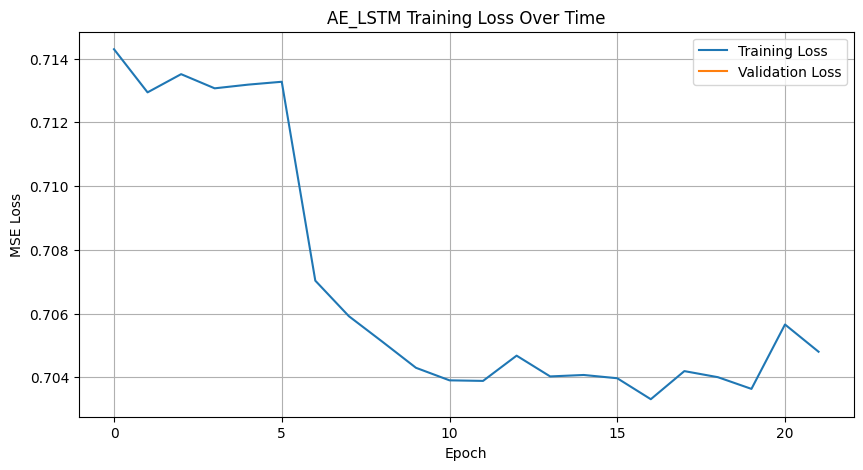

: 

In [ ]:
# Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history_callback.train_losses, label="Training Loss")
plt.plot(loss_history_callback.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AE_LSTM Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model.to(device)
model.eval()

with torch.no_grad():
    all_rec_errors = []
    # all_binary_preds = []

    # Process test data in batches
    for batch in test_dataloader:
        batch_data = batch[0].to(device)
        reconstructed_batch = model(batch_data)

        rec_error = ((batch_data - reconstructed_batch) ** 2).mean(dim=2, keepdim=True)
        # Convert to numpy for further processing
        rec_error_np = rec_error.cpu().numpy()
        # binary_predictions = (rec_error_np > self.threshold).astype(int)

        all_rec_errors.append(rec_error_np)
    # all_binary_preds.append(binary_predictions)

    # Concatenate results from all batches
    all_rec_errors = np.concatenate(all_rec_errors, axis=0)
    # all_binary_preds = np.concatenate(all_binary_preds, axis=0)
    # all_binary_preds = self.go_back_to_original_shape(all_binary_preds, len(data), self.seq_step)
    all_rec_errors = go_back_to_original_shape(
        all_rec_errors, X_test.shape[0], seq_step=1
    )
    roc_auc = roc_auc_score(y_test, all_rec_errors)

roc_auc